In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage import filters
from skimage.morphology import disk, square
import joblib

In [4]:
loaded_model = joblib.load("nres_cl_bufrac_pp_pixel_semi_balanced.pkl")

In [5]:
aoi_name = "AOI01_USA"
path_to_bufrac = r"C:\Users\david\Desktop\GHSL_Deliverables\Built_up_surface_layers\BUFRAC\{}_BUFRAC_10m_float64.tif".format(aoi_name)
path_to_mosaic = r"C:\Users\david\Desktop\GHSL_Deliverables\Intermediate_products\BUFRAC\S2_data\S2_AOIs\{}_S2_L1C.tif".format(aoi_name)

# load data and metadata
with rasterio.open(path_to_bufrac) as src:
    bufrac = src.read(1)
    bufrac_meta = src.profile

with rasterio.open(path_to_mosaic) as src:
    red_band = src.read(1)
    green_band = src.read(2)
    blue_band = src.read(3)
    nir_band = src.read(4)
    mosaic_meta = src.profile

In [21]:
mask = np.where((bufrac.ravel() > 0))

bufrac_nres = bufrac.ravel()[mask]
green_nres = green_band.ravel()[mask]
red_nres = red_band.ravel()[mask]
blue_nres = blue_band.ravel()[mask]
nir_nres = nir_band.ravel()[mask]

df = pd.DataFrame()
df['bufrac']=pd.Series(bufrac_nres)
df['red']=pd.Series(red_nres)
df['blue']=pd.Series(blue_nres)
df['green']=pd.Series(green_nres)
df['nir']=pd.Series(nir_nres)

In [22]:
X = df.values
y = loaded_model.predict(X)

C:\Users\david\anaconda3\envs\ghsl_base\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [23]:
nres = bufrac.copy()
nres.ravel()[mask] = y
res_layer = nres.reshape(bufrac_meta["width"], bufrac_meta["height"])

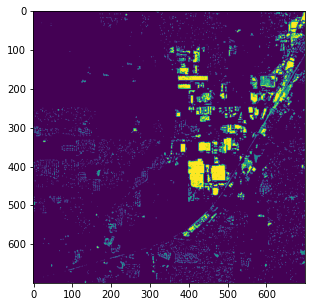

In [24]:
plt.figure(figsize=(5, 5))
plt.imshow(res_layer)

In [25]:
bufrac_meta.update(dtype="uint8")
res_layer = res_layer.reshape(1, bufrac_meta["width"], bufrac_meta["height"])

In [26]:
res_layer = res_layer.astype("uint8")

In [31]:
# majority filter to reduce salt and pepper effect
D = (res_layer > 0)[0]
no_bufrac_mask = (res_layer == 0)[0]

res_maj_filter = filters.rank.majority(res_layer[0], disk(3), mask=D)
res_maj_filter[no_bufrac_mask] = 0

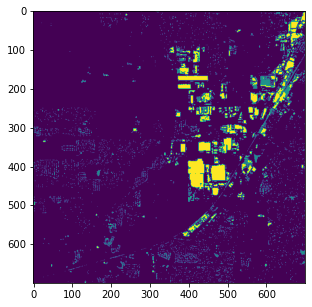

In [32]:
plt.figure(figsize=(5, 5))
plt.imshow(res_maj_filter)

In [748]:
# save results
with rasterio.open("{}_RES_NRES_10m_uin8.tif".format(aoi_name), 'w', **bufrac_meta) as dst:
        dst.write(res_maj_filter.reshape(1, bufrac_meta["width"], bufrac_meta["height"]))